<a href="https://colab.research.google.com/github/ngupta23/colab_notebooks/blob/master/AutoencoderTown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders
Code inspired by [this amazing keras blog post](https://blog.keras.io/building-autoencoders-in-keras.html). 

In this notebook we will learn about autoencoders, and go from the most simple possible of the autoencoders to the modern, complex, variational autoencoder, and discuss their various applications.

## Contents
* Simple fully connected autoencoder
* Sparse autoencoder
* Deep autoencoder
* Convolutional autoencoder
* Denoising autoencoder
* Sequence-to-sequence autoencoder
* Variational autoencoder

## What is an Autoencoder?
An autoencoder is a special type of neural network which really can be viewed as two NNs: an encoder and a decoder.

### Encoder
The encoder network consists of the following:
* An input layer with the same number of nodes as the data has dimensions
* Some hidden layers
* An output layer with the number of nodes equal to the number of dimensions you would like the encoded representation of your data to be.

The *encoder* learns a function, $h(x)$, which maps your data, which has $N$ dimensions (considering a matrix, a $(m, N)$ matrix), into a representation, or embedding, which has $D$ dimensions (a $(m, D)$ matrix). That function which the autoencoder learns can be represented mathematically as:

$$h(x) :: \begin{bmatrix}
a_0 & .. & .. & a_N \\
b_0 & .. & .. & b_N \\
.. & .. & .. & .. \\
m_0 & .. & .. & m_N 
\end{bmatrix} \rightarrow
\begin{bmatrix}
a_0  & .. & a_D \\
b_0 & .. & b_D \\
..  & .. & .. \\
m_0  & .. & m_D 
\end{bmatrix}
 $$
### Decoder
The decoder network is a network which is symmetric to the encoder network. That is it consists of:
* An input layer with $D$ nodes
* Some hidden layers
* An output layer with $N$ nodes

The decoder learns a function $g(x)$ which maps your $D$ dimensionsal embedding into $N$ dimensions, or:

$$
g(x) :: \begin{bmatrix}
a_0  & .. & a_D \\
b_0 & .. & b_D \\
..  & .. & .. \\
m_0  & .. & m_D 
\end{bmatrix} \rightarrow \begin{bmatrix}
a_0 & .. & .. & a_N \\
b_0 & .. & .. & b_N \\
.. & .. & .. & .. \\
m_0 & .. & .. & m_N 
\end{bmatrix} $$

### Autoencoder
The autoencoder combines these two functions, learning to first represent $N$ dimensional data to $D$ dimensional data, and then map that back into its original form

### Autoencoder loss

The autoencoder tries to make the output look just like the input, so the loss is more or less the difference between the input and output. Mathematically:

$$ L \sim x - g(h(x))$$

Now hopefully we more or less understand whats going on! Lets go ahead and get going!

In [0]:
!pip install Keras
!pip install tensorflow
!pip install matplotlib

# Simplest possible autoencoder
Here we will design the simplest possible autoencoder

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np

In [0]:
# load data
(x_train, _), (x_test, _) = mnist.load_data()

# Next, we want to normalize the data to be between 0 and 1
# and flatten images from 28x28 to vectors of length 784

def normalize_flatten(x):
  x = x.astype('float32')/255.
  return(x.reshape((len(x), np.prod(x.shape[1:]))))

x_train, x_test = (normalize_flatten(x) for x in [x_train, x_test])
print(x_train.shape)

(60000, 784)


Next lets build the autoencoder. Note how we use the Keras Model API to extract the different stages!


In [0]:
# number of dimensions we want to encode in
encoding_dim = 32 # 24.5x compression

# placeholder for input
input_img = Input(shape = (784,))

# encoder layer
# code is Dense(specs)(input to layer)
# note this allows for construction with for loops!
encoded = Dense(encoding_dim, activation = 'relu')(input_img)

# decoder layer
decoded = Dense(784, activation = 'sigmoid')(encoded)

# make the full autoencoder
simple_ae = Model(input_img, decoded)

# make a separate model to get embeddings
encoder = Model(input_img, encoded)

# decoder model

encoded_input = Input(shape = (encoding_dim,)) # placeholder
decoder_layer = simple_ae.layers[-1] # last layer
decoder = Model(encoded_input, decoder_layer(encoded_input))

# configure model
simple_ae.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
simple_ae.fit(x_train, x_train, 
              epochs = 50, batch_size = 256, shuffle = True,
              validation_data = (x_test, x_test))




Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 6s 101us/step - loss: 0.3538 - val_loss: 0.2719
Epoch 2/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2654 - val_loss: 0.2554
Epoch 3/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.2451 - val_loss: 0.2327
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2247 - val_loss: 0.2146
Epoch 5/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.2089 - val_loss: 0.2010
Epoch 6/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1973 - val_loss: 0.1911
Epoch 7/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1884 - val_loss: 0.1833
Epoch 8/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1813 - val_loss: 0.1770
Epoch 9/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1753 - val_loss: 0.1

Lets look at the decoded representation of the images next to the actual images!!

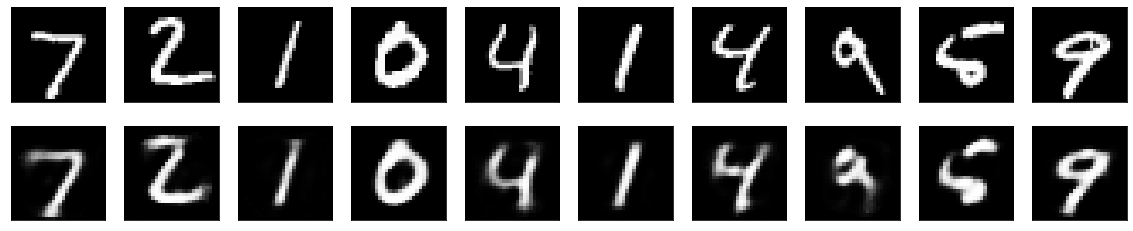

In [0]:
# predict 
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# view
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Sparse autoencoder!

Uses: make other models faster with sparse representation of data. A lot of the important powerful neural nets in the last 10-20 years have used these.

Our previous model was basically a more complex PCA, in fact it can be viewed as an approximation of PCA. However, we can constrain further and use a sparse representation of the data, meaning fewer units "fire" at once


In [0]:
from keras import regularizers

encoding_dim =  32

input_img = Input(shape = (784,))

# dense, L1 regurlarized layer
# this makes not all of the nodes fire at once, sparsifying the output

encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-5))(input_img)
decoded = Dense(784, activation = 'sigmoid')(encoded)

sparse_ae = Model(input_img, decoded)

encoder = Model(input_img, encoded)

# decoder model
encoded_input = Input(shape = (encoding_dim,)) # placeholder
decoder_layer = simple_ae.layers[-1] # last layer
decoder = Model(encoded_input, decoder_layer(encoded_input))

sparse_ae.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')





In [0]:
sparse_ae.fit(x_train, x_train, 
              epochs = 100, batch_size = 256, shuffle = True,
              validation_data = (x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.6712 - val_loss: 0.6485
Epoch 2/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.4999 - val_loss: 0.3278
Epoch 3/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.3179 - val_loss: 0.3104
Epoch 4/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.3067 - val_loss: 0.3032
Epoch 5/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.3009 - val_loss: 0.2986
Epoch 6/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2969 - val_loss: 0.2951
Epoch 7/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.2938 - val_loss: 0.2923
Epoch 8/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.2913 - val_loss: 0.2900
Epoch 9/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.2891 - val_loss: 0.2

# Deep Autoencoder

We will make our autoencoder now with a stack of layers, learning a deeper representation of the data
## Applications:

Like our small autoencoder but more powerful, more nonlinear representations

In [0]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

deep_ae = Model(input_img, decoded)
deep_ae.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')

In [0]:
deep_ae.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.3203 - val_loss: 0.2637
Epoch 2/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2578 - val_loss: 0.2523
Epoch 3/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.2432 - val_loss: 0.2354
Epoch 4/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.2268 - val_loss: 0.2184
Epoch 5/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.2122 - val_loss: 0.2052
Epoch 6/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.2010 - val_loss: 0.1944
Epoch 7/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.1916 - val_loss: 0.1861
Epoch 8/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.1840 - val_loss: 0.1787
Epoch 9/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.1765 - val_loss: 0.1

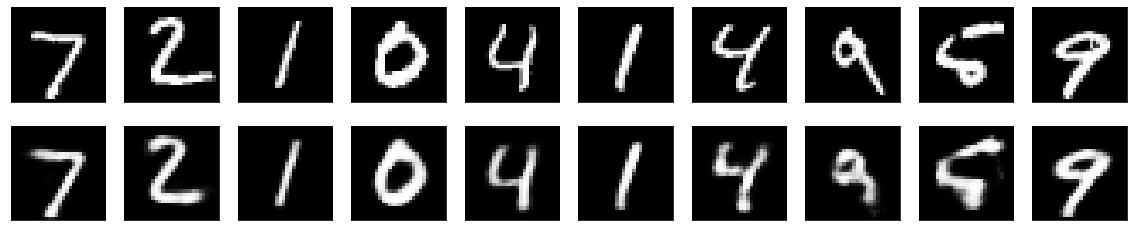

In [0]:
decoded_imgs = deep_ae.predict(x_test)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional autoencoder
An autoencoder made out of convolutional layers!!
For image processing this is desirable

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)




autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
# Data loading
 (x_train, _), (x_test, _) = mnist.load_data()

# data reshaping
# we want to normalize the pixel values between 0 and 1, along with normal stuff

def normalize_convolutional(x):
  x = x.astype('float32')/255.
  x = np.reshape(x, (len(x), 28, 28, 1))
  return(x)

x_train, x_test = (normalize_convolutional(x) for x in [x_train, x_test])
print(x_train.shape)

(60000, 28, 28, 1)


In [0]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 126us/step - loss: 0.2163 - val_loss: 0.1686
Epoch 2/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.1587 - val_loss: 0.1516
Epoch 3/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.1458 - val_loss: 0.1432
Epoch 4/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.1378 - val_loss: 0.1321
Epoch 5/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.1322 - val_loss: 0.1290
Epoch 6/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.1286 - val_loss: 0.1255
Epoch 7/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.1255 - val_loss: 0.1273
Epoch 8/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.1231 - val_loss: 0.1212
Epoch 9/50
60000/60000 [==============================] - 4s 58us/step - loss: 0.1213 - val_loss: 0.1205
Epoc

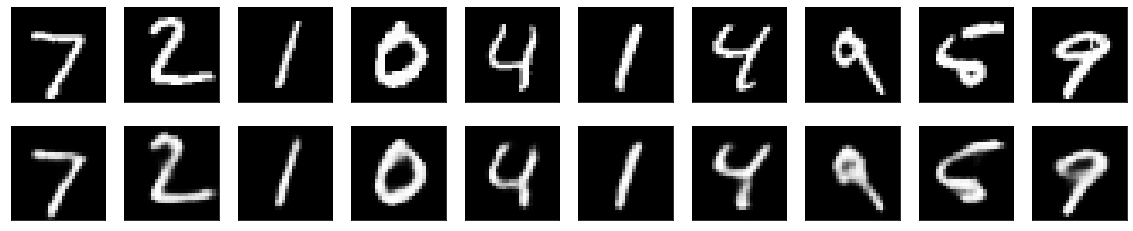

In [0]:
decoded_imgs = autoencoder.predict(x_test)
encoded_imgs = encoder.predict(x_test)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


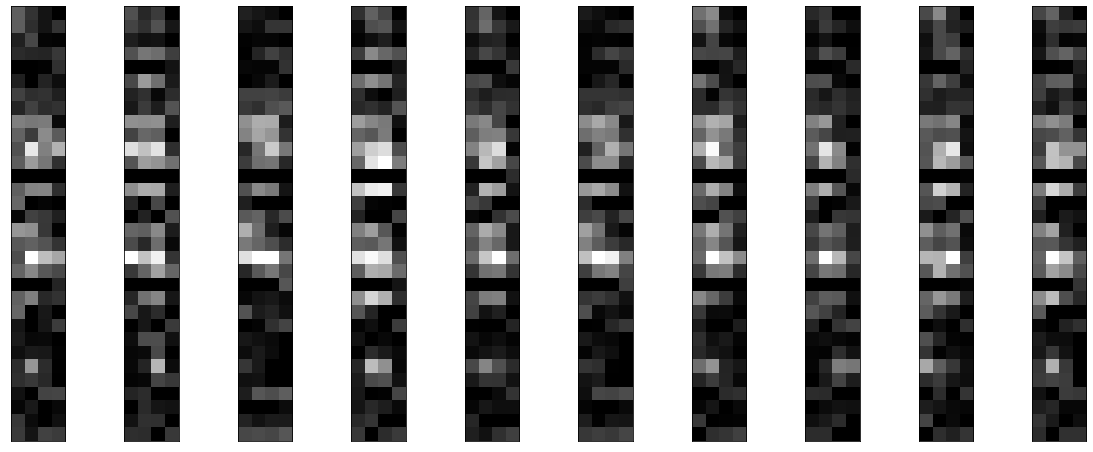

In [0]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Autoencoder

Applications: obvious!
We can denoise images, documents, and videos with autoencoders, and maybe also think about applications to adversarial attacks. See bottom for references to a lot of cool applications for this.

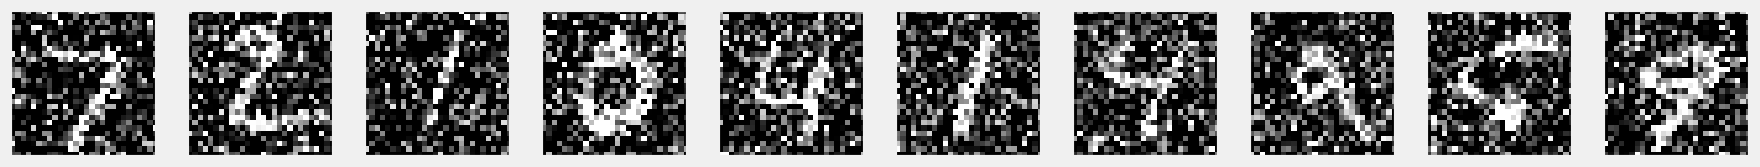

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()

def normalize_noisy(x, noise_factor):
  x = x.astype('float32') / 255.
  x = np.reshape(x, (len(x), 28, 28, 1))
  x_n = x + noise_factor*np.random.normal(loc = 0.0, scale = 1.0, size = x.shape)
  x_n = np.clip(x_n, 0., 1.)
  return(x, x_n)

(x_train, x_train_noisy), (x_test, x_test_noisy) = (normalize_noisy(x, 0.5) for x in [x_train, x_test])




n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



In [0]:
# let's train the previous autoencoder for 100 epochs on this data!
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.1201 - val_loss: 0.1191
Epoch 2/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.1202 - val_loss: 0.1186
Epoch 3/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.1199 - val_loss: 0.1176
Epoch 4/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1199 - val_loss: 0.1185
Epoch 5/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.1198 - val_loss: 0.1202
Epoch 6/100
60000/60000 [==============================] - 4s 61us/step - loss: 0.1199 - val_loss: 0.1201
Epoch 7/100
60000/60000 [==============================] - 4s 63us/step - loss: 0.1200 - val_loss: 0.1169
Epoch 8/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.1202 - val_loss: 0.1195
Epoch 9/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.1201 - val_loss: 0.1

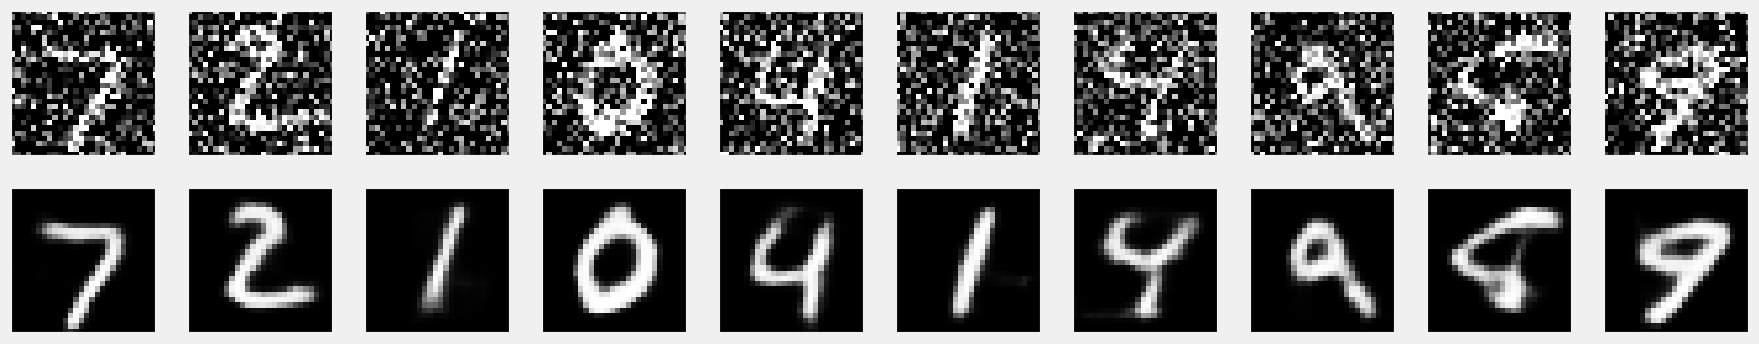

In [0]:
# predict embeddings and the actual data

decoded_imgs = autoencoder.predict(x_test_noisy)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Sequence to Sequence autoencoder

For time series!! We will not run the code in this example, but the takeaway is we can build an AE out of any network type

In [0]:
# NOT RUN

from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

latent_dim(100)

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)


# Variational autoencoder

![alt text](https://i.kinja-img.com/gawker-media/image/upload/s--eiIVX4Oq--/c_fill,fl_progressive,g_center,h_900,q_80,w_1600/yccc3f4vcwsxyj6eydy2.jpg)


This is a huge step in sophistication, and so we will spend some time talking about it and the ideas behind it. In the previous examples. we learned an arbitrary function, best viewed as a mapping from $N$ dimensions to $D$ dimensions. In the sparse autoencoder example, we learned we can constrain the autoencoder to learn a sparse function. Let us think for a moment of other constraints we can apply to the autoencoder.

In this case, it would be really useful to learn instead of just a mapping, the parameters of a probability distribution which can represent our data. This is what a variational autoencoder does, it learns a [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model) of the data, or in layman's terms a probability distribution for our data. We can then actually sample this probability distribution to generate new examples. 

This is a really powerful result. It means that VAEs can be used as a generative model, and have been shown to [outperform GANs](https://syncedreview.com/2019/06/06/going-beyond-gan-new-deepmind-vae-model-generates-high-fidelity-human-faces/) in face generation by DeepMind. There are also tons of incredible applications for latent space models, which we will discuss after the example.

# Building the network
First, lets set up our data!

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255




Next, lets design our network parameters. We will save the input shape, an intermediate number of dimensions for our hidden layer, a number of latent dimensions (number of parameters of our latent model), batch size, and number of epochs

In [0]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

Next, lets build our encoder network, which maps inputs to latent distribution parameters

In [0]:
from keras.layers import Lambda, Input, Dense
import keras.backend as K

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

We use these new parameters to sample new points from the latent space!



In [0]:
import tensorflow.backend as K

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return(z_mean + K.exp(0.5 * z_log_var) * epsilon)



z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


Next, we can map these sampled points back to our reconstruction!


In [0]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

This allows us to create 3 models: an end-to-end autoencoder for mapping inputs to latent spaces to reconstructions, an encoder which maps inputs to latent spaces, and a generator which samples the latent space and returns the corresponsing samples

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_54[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_54[0][0]                   
____________________________________________________________________________________________

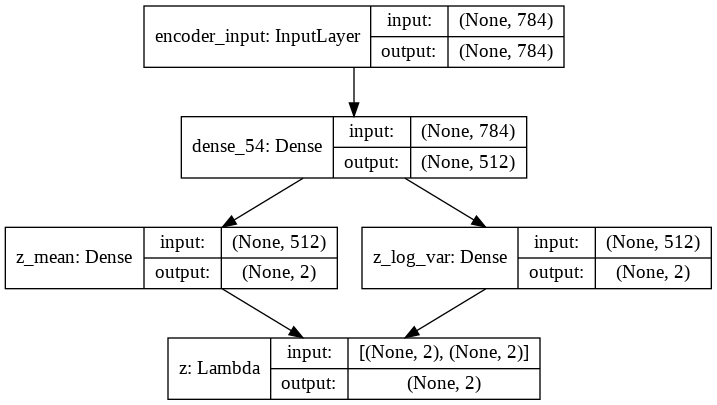

In [0]:
from keras.utils import plot_model
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True)







Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_66 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


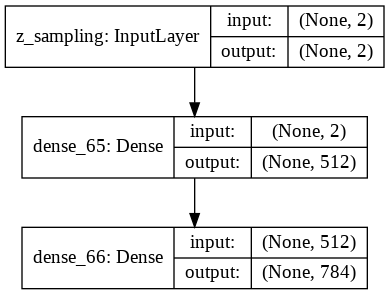

In [0]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True)


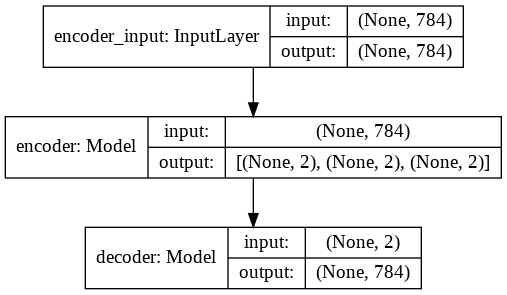

In [0]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

plot_model(vae, show_shapes=True)

Next, we can train everything using the full autoencoder. Lets define a loss function, which uses the combination of the image reconstruction and the divergence from the original probability distribution:

---



In [0]:
from keras.losses import mse, binary_crossentropy
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Now lets train!!

In [0]:
  vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 143.8214 - val_loss: 149.6655
Epoch 2/50
60000/60000 [==============================] - 2s 38us/step - loss: 143.7867 - val_loss: 149.7945
Epoch 3/50
60000/60000 [==============================] - 2s 39us/step - loss: 143.7234 - val_loss: 149.7686
Epoch 4/50
60000/60000 [==============================] - 2s 38us/step - loss: 143.7288 - val_loss: 149.8885
Epoch 5/50
60000/60000 [==============================] - 2s 39us/step - loss: 143.6994 - val_loss: 149.6858
Epoch 6/50
60000/60000 [==============================] - 2s 39us/step - loss: 143.6319 - val_loss: 149.9095
Epoch 7/50
60000/60000 [==============================] - 2s 38us/step - loss: 143.5652 - val_loss: 149.5329
Epoch 8/50
60000/60000 [==============================] - 2s 38us/step - loss: 143.5932 - val_loss: 149.7698
Epoch 9/50
60000/60000 [==============================] - 2s 39us/step - loss:

Lets look at the latent space! This is really cool

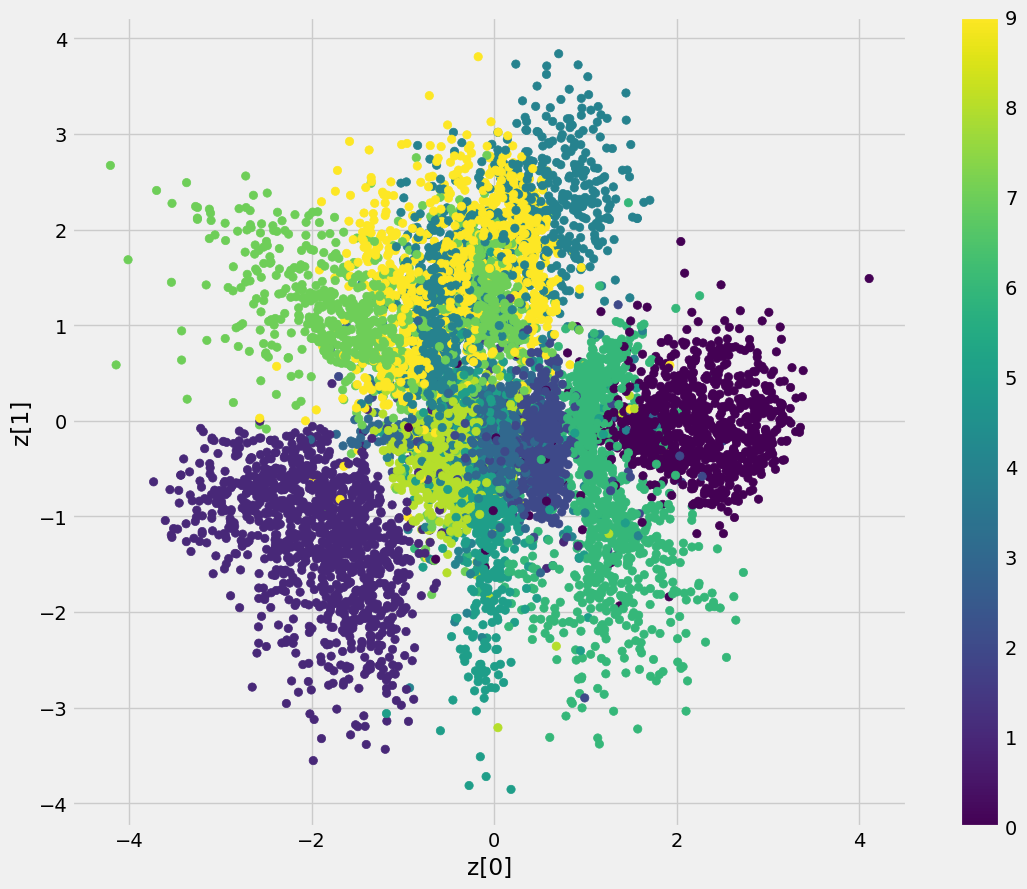

In [0]:
plt.style.use('fivethirtyeight')
def plot_latent(model,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder = model
    x_test, y_test = data


    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=(y_test))
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_latent(encoder, (x_test, y_test))

We can also plot new digits. We will sample latent points at regular interval, generate the digit for these points, and give us a visualization of the latent manifold!


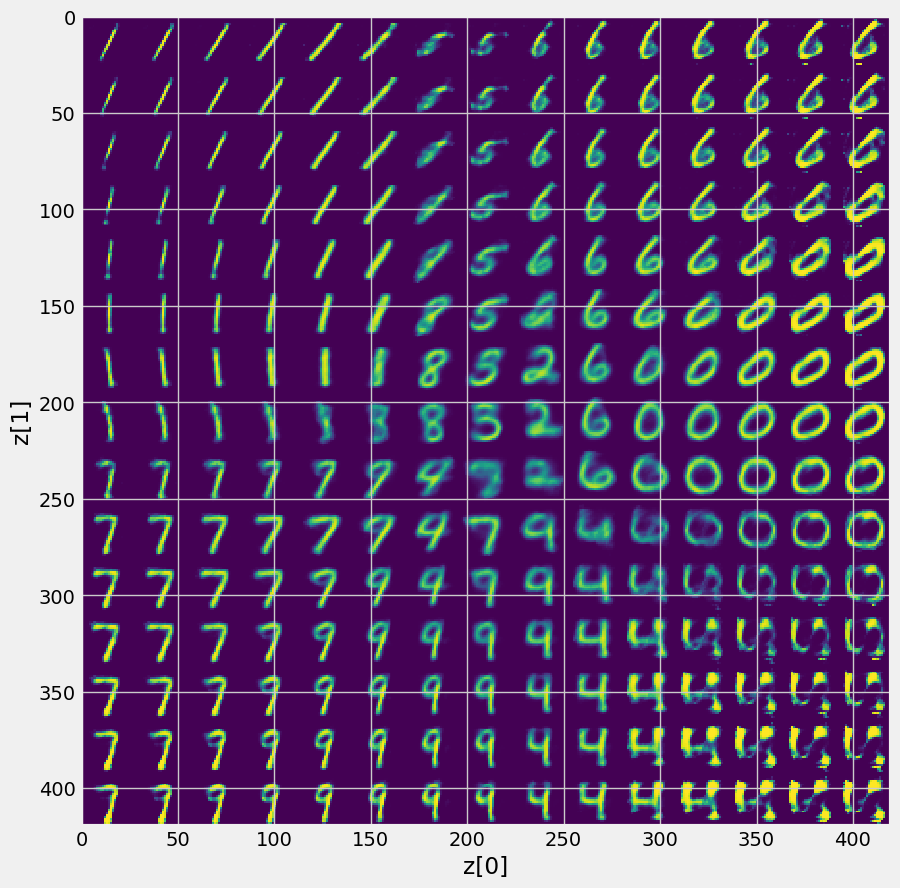

In [0]:
def plot_generated(model,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    decoder = model
    x_test, y_test = data
    n = 15
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()

plot_generated(decoder, (x_test, y_test))

# Further reading on applications, discussed in video

* [Latent Shoe Math](https://medium.com/engineeringatgoat/how-goat-taught-a-machine-to-love-sneakers-e4a97cda71b1)
* [Making video quality better](https://towardsdatascience.com/improving-pewdiepies-camera-quality-with-autoencoders-583635de1cde)
* [Exploring Jet Engine design with VAEs](http://cs229.stanford.edu/proj2017/final-reports/5231979.pdf)
* [Purifying adversarial attacks with VAEs](https://arxiv.org/pdf/1903.00585.pdf)
* [Latent representation learning for style control](https://arxiv.org/abs/1812.04342)
* Deep clustering in general relies on autoencoders, lots of cool stuff there
* [Noisy speech recognition with denoising Convolutional Autoencoders](http://cs231n.stanford.edu/reports/2015/pdfs/Final_Report_mkayser_vzhong.pdf)
* [Predicting Hidden Faces with LSTM autoencoders](https://arxiv.org/pdf/1612.08534.pdf)
* [Non nervous explanation of LSTM autoencoders](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352)
* [Extreme event classification with LSTM autoencoders](https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb)
* [Molecule Design with Graph VAEs](https://github.com/Microsoft/constrained-graph-variational-autoencoder)
  * [arxiv](https://github.com/Microsoft/constrained-graph-variational-autoencoder)
* [Contextual persona generating VAE chatbot (absolutely mind blowing)](https://arxiv.org/pdf/1905.12188.pdf)
* [Stochastic VAE for dialog generation](https://lili-mou.github.io/paper/2019-NAACL.pdf)
* [Convolutional VAE for text generation](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/d65f002f8aa2143cfd74c87a3ec5a23c07e77614.pdf)
* [VAEs make classical recommender systems obsolete](https://medium.com/snipfeed/how-variational-autoencoders-make-classical-recommender-systems-obsolete-4df8bae51546)
* [Music generation with hierarchical VAEs](https://nips2017creativity.github.io/doc/Hierarchical_Variational_Autoencoders_for_Music.pdf)
* [Intuition understanding for VAEs](https://www.topbots.com/intuitively-understanding-variational-autoencoders/)
* [Colorizing images with autoencoders](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/colorization-autoencoder-cifar10-3.4.1.py)
* [Deepfakes with autoencoders](https://medium.com/gradientcrescent/deepfaking-nicolas-cage-into-the-mcu-using-autoencoders-an-implementation-in-keras-and-tensorflow-ab47792a042f)